# Gravitational Orbits in Cartesian Coordinates

In [1]:
%matplotlib inline

import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

In [2]:
class Orbit:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r) = k r^n.
    """
    
    def __init__(self, m_1=1.,m_2=1.,G=1.):
        self.m_1 = m_1
        self.m_2 = m_2
        self.G = G
        
    def dz_dt(self, t, z):
        """
        This function returns the right-hand side of the diffeq: 
        [dz/dt d^2z/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        z : float\
            8-component vector with z(0) = x_1(t) and z(1) = x_dot_1(t)
                                    z(2) = y_1(t) and z(3) = y_dot_1(t)
                                    z(4) = x_2(t) and z(5) = x_dot_2(t)
                                    z(6) = y_2(t) and z(7) = y_dot_2(t)
        Returns
        """
        r_12 = np.sqrt((z[4]-z[0])**2 + (z[6]-z[2])**2)
        return [ \
                z[1], self.G *self.m_2 * (z[4] -z[0]) / r_12**3, \
                z[3], self.G *self.m_2 * (z[6] -z[2]) / r_12**3, \
                z[5], -self.G *self.m_1 * (z[4] -z[0]) / r_12**3, \
                z[7], -self.G *self.m_1 * (z[6] -z[2]) / r_12**3, \
               ]
    
    
    def solve_ode(self, t_pts, z_0,
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        """
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z_0, t_eval=t_pts, method='RK23', 
                             atol=abserr, rtol=relerr)
        
        x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = solution.y
        
        return x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2
    
    def solve_ode_Leapfrog(self, t_pts,z_0):
        
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, \
        x_2_0, x_dot_2_0, y_2_0, y_dot_2_0 = z_0
        
        #initialize the arrays with zeros
        num_t_pts = len(t_pts)
        
        x_1 = np.zeros(num_t_pts)
        x_dot_1 = np.zeros(num_t_pts)
        x_dot_1_half = np.zeros(num_t_pts)
        
        y_1 = np.zeros(num_t_pts)
        y_dot_1 = np.zeros(num_t_pts)
        y_dot_1_half = np.zeros(num_t_pts)
        
        x_2 = np.zeros(num_t_pts)
        x_dot_2 = np.zeros(num_t_pts)
        x_dot_2_half = np.zeros(num_t_pts)
        
        y_2 = np.zeros(num_t_pts)
        y_dot_2 = np.zeros(num_t_pts)
        y_dot_2_half = np.zeros(num_t_pts)
        
        #initial conditions
        x_1[0] = x_1_0
        x_dot_1[0] =x_dot_1_0
        
        x_2[0] = x_2_0
        x_dot_2[0] =x_dot_2_0
        
        y_1[0] = y_1_0
        y_dot_1[0] =y_dot_1_0
        
        y_2[0] = y_2_0
        y_dot_2[0] =y_dot_2_0
        
        #step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            z = [x_1[i], x_dot_1[i], y_1[i], y_dot_1[i], \
                x_2[i], x_dot_2[i], y_2[i], y_dot_2[i],]
            out = self.dz_dt(t,z)
            
            x_dot_1_half[i] = x_dot_1[i] + out[1] * delta_t/2.
            x_1[i+1] = x_1[i] + x_dot_1_half[i] * delta_t
            
            y_dot_1_half[i] = y_dot_1[i] + out[3] * delta_t/2.
            y_1[i+1] = y_1[i] + y_dot_1_half[i] * delta_t
            
            x_dot_2_half[i] = x_dot_2[i] + out[5] * delta_t/2.
            x_2[i+1] = x_2[i] + x_dot_2_half[i] * delta_t
            
            y_dot_2_half[i] = y_dot_2[i] + out[7] * delta_t/2.
            y_2[i+1] = y_2[i] + y_dot_2_half[i] * delta_t
            
            z = [x_1[i+1], x_dot_1[i], y_1[i+1], y_dot_1[i], \
                x_2[1+1], x_dot_2[i], y_2[i+1], y_dot_2[i]]
            out = self.dz_dt(t,z)
            
            x_dot_1[i+1] = x_dot_1_half[i] + out[1] * delta_t/2.
            y_dot_1[i+1] = y_dot_1_half[i] + out[3] * delta_t/2.
            x_dot_2[i+1] = x_dot_2_half[i] + out[5] * delta_t/2.
            y_dot_2[i+1] = y_dot_2_half[i] + out[7] * delta_t/2.
            
        return x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2
    

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Make plots

In [5]:
orbit_labels = (r'$x$', r'$y$')

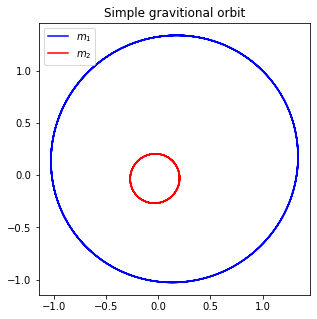

In [6]:
G = 1.
m_1 = 1.
m_2 = 5.

t_start = 0.
t_end = 20.
delta_t = 0.01
t_pts = np.arange(t_start, t_end+delta_t, delta_t) 


o1 = Orbit(m_1, m_2, G)

x_1_0, x_dot_1_0 = 1., -1.
y_1_0, y_dot_1_0 = 1., 1.
x_2_0, x_dot_2_0 = -(m_1 / m_2) * x_1_0, -(m_1 / m_2) * x_dot_1_0
y_2_0, y_dot_2_0 = -(m_1 / m_2) * y_1_0, -(m_1 / m_2) * y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, \
        x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode(t_pts, z_0)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1) 

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitional orbit')
ax.legend()
ax.set_aspect(1)

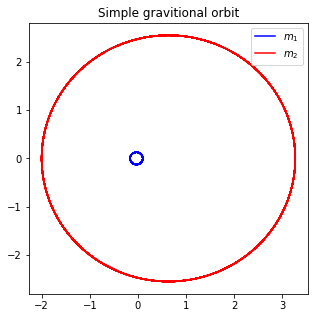

In [7]:
G = 20.
m_1 = 20.
m_2 = 1.

t_start = 0.
t_end = 20.
delta_t = 0.01
t_pts = np.arange(t_start, t_end+delta_t, delta_t) 

o1 = Orbit(m_1, m_2, G)

x_1_0, x_dot_1_0 = 0.1, 0.
y_1_0, y_dot_1_0 = 0., 0.75
x_2_0, x_dot_2_0 = -(m_1 / m_2) * x_1_0, -(m_1 / m_2) * x_dot_1_0
y_2_0, y_dot_2_0 = -(m_1 / m_2) * y_1_0, -(m_1 / m_2) * y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = \
o1.solve_ode(t_pts, z_0)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitional orbit')
ax.legend()
ax.set_aspect(1)

In [8]:
#Leapfrog method

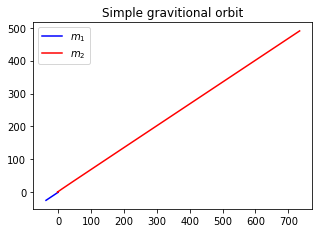

In [9]:
G = 20.
m_1 = 20.
m_2 = 1.

t_start = 0.
t_end = 20.
delta_t = 0.01
t_pts = np.arange(t_start, t_end+delta_t, delta_t) 

o1 = Orbit(m_1, m_2, G)

x_1_0, x_dot_1_0 = 0.1, 0.
y_1_0, y_dot_1_0 = 0., 0.75
x_2_0, x_dot_2_0 = -(m_1 / m_2) * x_1_0, -(m_1 / m_2) * x_dot_1_0
y_2_0, y_dot_2_0 = -(m_1 / m_2) * y_1_0, -(m_1 / m_2) * y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = \
o1.solve_ode_Leapfrog(t_pts, z_0)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitional orbit')
ax.legend()
ax.set_aspect(1)

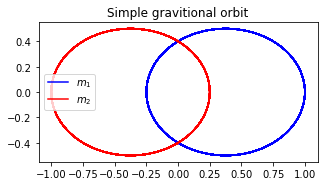

In [10]:
G = 10.
m_1 = 1.
m_2 = 1.

t_start = 0.
t_end = 50.
delta_t = 0.01
t_pts = np.arange(t_start, t_end+delta_t, delta_t) 

o1 = Orbit(m_1, m_2, G)

x_1_0, x_dot_1_0 = 1., 0.
y_1_0, y_dot_1_0 = 0., 1.
x_2_0, x_dot_2_0 = -(m_1 / m_2) * x_1_0, -(m_1 / m_2) * x_dot_1_0
y_2_0, y_dot_2_0 = -(m_1 / m_2) * y_1_0, -(m_1 / m_2) * y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = \
o1.solve_ode(t_pts, z_0)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)           

start, stop = start_stop_indices(t_pts, t_start, t_end)    
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitional orbit')
ax.legend(loc='center left')
ax.set_aspect(1)

In [11]:
from matplotlib import animation, rc
from IPython.display import HTML

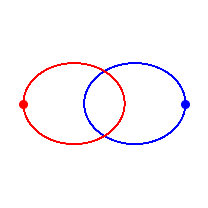

In [12]:
x_min = -1.2
x_max = -x_min
y_min = -1.2
y_max = -y_min

fig_anim = plt.figure(figsize=(5,3), num='Orbits')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min, x_max)
ax_anim.set_ylim(y_min, y_max)

ln1_anim, = ax_anim.plot(x_1, y_1, color='blue', lw=1)
ln2_anim, = ax_anim.plot(x_2, y_2, color='red', lw=1)

pt1_anim, = ax_anim.plot(x_1[0], y_1[0], 'o', markersize=8, color='blue')
pt2_anim, = ax_anim.plot(x_2[0], y_2[0], 'o', markersize=8, color='red')

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()

In [13]:
def animate_orbits(i):
    
    i_skip = 1 * i
    pt1_anim.set_data(x_1[i_skip], y_1[i_skip])
    pt2_anim.set_data(x_2[i_skip], y_2[i_skip])
    
    return (pt1_anim, pt2_anim)

In [14]:
frame_interval = 10.
frame_number = 1001
anim = animation.FuncAnimation(fig_anim,
                              animate_orbits,
                              init_func=None,
                              frames=frame_number,
                              interval=frame_interval,
                              blit=True,
                              repeat=False)
HTML(anim.to_jshtml())